# PUMP IT

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

An interactive course exploring this dataset is currently offered by DataCamp.com!

Competition End Date: Jan. 28, 2017, 11:59 p.m.

This competition is for learning and exploring, so the deadline may be extended in the future.


* [Git Hub Repo](https://github.com/msampathkumar/datadriven_pumpit)
* [Git Hub Report](https://github.com/msampathkumar/datadriven_pumpit/blob/master/capstone_proposal.mdown)
* [Features Details](https://www.drivendata.org/competitions/7/page/25/)



## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

np.random.seed(69572)

%matplotlib inline

%load_ext writeandexecute

# plt.figure(figsize=(120,10))

small = (4,3)
mid = (10, 8)
large = (12, 8)

'writeandexecute' magic loaded.


## Custom Functions

### MarkUP Fns

In [2]:
from __future__ import absolute_import
from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)
import sys
from StringIO import StringIO
from markdown import markdown
from IPython.core.display import HTML
 
@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

### DataFrame Value Counts

In [3]:
def raw_markup_value_counts(dataframe, max_print_value_counts=30, show_plots=False):
    '''
    prints value counts of each feature in data frame
    '''
    mydf = pd.DataFrame.copy(dataframe)
    i = 0
    raw_markup_data = []
    pp = raw_markup_data.append
    pp('''|Col ID|Col Name|UniqCount|Col Values|UniqValCount|''')
    pp('''|------|--------|---------|----------|------------|''')
    for col in mydf.dtypes.index:
        i += 1
        sam = mydf[col]
        tmp = len(sam.value_counts())
        if tmp < max_print_value_counts:
            flag = True
            for key, val in dict(sam.value_counts()).iteritems():
                if flag:
                    pp('|%i|%s|%i|%s|%s|' % (
                            i, col, len(sam.value_counts()), key, val))
                    flag = False
                else:
                    pp('||-|-|%s|%s|' % (key, val))
            if show_plots:
                plt.figure(i)
                ax = sam.value_counts().plot(kind='barh', figsize=(12, 5))
                _ = plt.title(col.upper())
                _ = plt.xlabel('counts')
        else:
            pp('|%i|%s|%i|||' % (i, col, len(sam.value_counts())))
    return raw_markup_data

#### Confusion Matrix

In [4]:
from __future__ import division
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

    
def confusion_maxtrix_stuff(y_test, y_pred, class_names):
    '''
    Example
    >>> confusion_maxtrix_stuff(y_test,
                                y_pred,
                                class_names=RAW_y.status_group.value_counts().keys()
                                ):
    '''
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

## Import & Explore Data

In [5]:
RAW_X = pd.read_csv('traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('test_set_values.csv', index_col='id')

## Pre Processing

Log_Lat_Help: [Link](http://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)

#### Num Data Tranformation

* date_recorded --> Int
* longitude --> Float(less precision)
* latitude --> Float(less precision)
* public_meeting --> Bool
* permit --> Bool

In [6]:
from datetime import datetime
strptime = datetime.strptime

DATE_FORMAT = "%Y-%m-%d"
REFERENCE_DATE_POINT = strptime('2000-01-01', DATE_FORMAT)

# Reducing geo location precision to 11 meters
LONG_LAT_PRECISION = 0.001

def sam_datetime_to_number(x):
    return (strptime(str(x), DATE_FORMAT) - REFERENCE_DATE_POINT).days


# Transforming Date to Int.
if RAW_X.date_recorded.dtype == 'O':
    RAW_X.date_recorded = RAW_X.date_recorded.map(sam_datetime_to_number)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.map(sam_datetime_to_number)


# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'latitude'][RAW_X.latitude < -1.0].values)
if not RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'].empty:
    RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X.latitude >= -1.0, u'latitude'] = _


# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'longitude'][RAW_X[u'longitude'] > 1.0].values)
if not RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'].empty:
    RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X[u'longitude'] <= 1.0, u'longitude'] = _


# Reducing Precision of Lat.
if RAW_X.longitude.mean() < 50:
    RAW_X.longitude = RAW_X.longitude // LONG_LAT_PRECISION
    RAW_X.latitude = RAW_X.latitude // LONG_LAT_PRECISION
    RAW_TEST_X.longitude = RAW_TEST_X.longitude // LONG_LAT_PRECISION
    RAW_TEST_X.latitude = RAW_TEST_X.latitude // LONG_LAT_PRECISION

    
# Filling Missing/OUTLIAR Values
if RAW_X.public_meeting.dtype != 'bool':
    RAW_X.public_meeting = RAW_X.public_meeting == True
    RAW_TEST_X.public_meeting = RAW_TEST_X.public_meeting == True


if RAW_X.permit.dtype != 'bool':
    RAW_X.permit = RAW_X.permit == True
    RAW_TEST_X.permit = RAW_TEST_X.permit == True

In [7]:
if list(RAW_TEST_X.dtypes[RAW_TEST_X.dtypes != RAW_X.dtypes]):
    raise Exception('RAW_X.dtypes and RAW_TEST_X.dtypes are not in Sync')

#### Text Data Tranformations

In [8]:
def text_transformation(name):
    if name:
        name = name.lower().strip()
        name = ''.join([i if 96 < ord(i) < 128 else ' ' for i in name])
        if 'and' in name:
            name = name.replace('and', ' ')
        if '/' in name:
            name = name.replace('/', ' ')
        while '  ' in name:
            name = name.replace('  ', ' ')
        return name.strip()
    return

for col in RAW_X.dtypes[RAW_X.dtypes == object].index:
    aa = len(RAW_X[col].unique())
    RAW_X[col] = RAW_X[col].fillna('').apply(text_transformation)
    RAW_TEST_X[col] = RAW_TEST_X[col].fillna('').apply(text_transformation)
    bb = len(RAW_X[col].unique())
    if aa != bb:
        print col, aa, bb

funder 1898 1881
installer 2146 1867
wpt_name 37400 36717
subvillage 19288 19176
scheme_name 2697 2485


#### Cols vs Uniq distribution

### Data Distribution

## Vector Transformation


* Feature Selection:
    http://machinelearningmastery.com/feature-selection-machine-learning-python/

In [9]:
from collections import defaultdict
from sklearn import preprocessing

# http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
d = defaultdict(preprocessing.LabelEncoder)

# Labels Fit
sam = pd.concat([RAW_X, RAW_TEST_X]).apply(lambda x: d[x.name].fit(x))

# Labels Transform - Training Data
X = RAW_X.apply(lambda x: d[x.name].transform(x))
TEST_X = RAW_TEST_X.apply(lambda x: d[x.name].transform(x))

le = preprocessing.LabelEncoder().fit(RAW_y[u'status_group'])
y = le.transform(RAW_y[u'status_group'])

In [ ]:
# g = sns.PairGrid(X[:1000])
# g.map(plt.scatter);

### UniVariate Analysis

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [11]:
test = SelectKBest(score_func=chi2, k=30)
fit = test.fit(X, y)
cols_names = RAW_X.columns

np.set_printoptions(precision=2)
print(fit.scores_), len(fit.scores_)

col_importances = list(zip(fit.scores_, cols_names))
col_importances.sort(reverse=True)
selected_cols =  [_[-1] for _ in col_importances[:30] ]

[  7.49e+04   9.58e+03   7.19e+04   5.13e+05   2.42e+04   4.86e+05
   5.24e+04   1.18e+05   2.11e+02   2.66e+02   1.36e+04   1.81e+03
   1.70e+03   6.45e+02   9.15e+03   3.11e+03   5.16e+03   4.42e+01
        nan   4.39e+02   7.78e+04   2.15e+01   2.43e+04   2.64e+03
   3.43e+03   4.96e+03   1.77e+02   3.02e+01   8.66e+02   4.63e+02
   9.91e-01   4.23e+02   6.73e+02   6.73e+02   4.59e+02   5.68e+02
   3.95e+02   3.35e+03   2.54e+03] 39


In [12]:
features = pd.DataFrame(fit.transform(X))
features.columns = selected_cols

In [13]:
print len(X.columns), features.shape, len(y)

39 (59400, 30) 59400


In [16]:
X = pd.DataFrame(fit.transform(X))
TEST_X = pd.DataFrame(fit.transform(TEST_X))

X.columns = selected_cols
TEST_X.columns = selected_cols

### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# feature extraction
pca = PCA(n_components=18)
fit = pca.fit(X)

In [ ]:
plt.scatter (range(len(fit.explained_variance_ratio_)), fit.explained_variance_ratio_.cumsum())

In [ ]:
X = pca.transform(X)
TEST_X = pca.transform(TEST_X)

## Test-Train Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42, stratify=y)

## Model Training

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight="balanced_subsample", n_jobs=-1)
# class_weight="balanced_subsample"/"balanced"
# criterion="gini"/"entropy"

In [86]:
clf

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [87]:
clf = clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)
clf.score(X_test, y_test) # 0.79303132333435367 # 0.80252525252525253 # 0.80303030303030298 # 0.80345117845117842

# 0.79814814814814816
# (n_estimators=100, class_weight="balanced_subsample", n_jobs=-1) 0.80782828282828278
# (n_estimators=100, class_weight="balanced_subsample", n_jobs=-1) 0.81186868686868685

0.81186868686868685

In [81]:
clf?

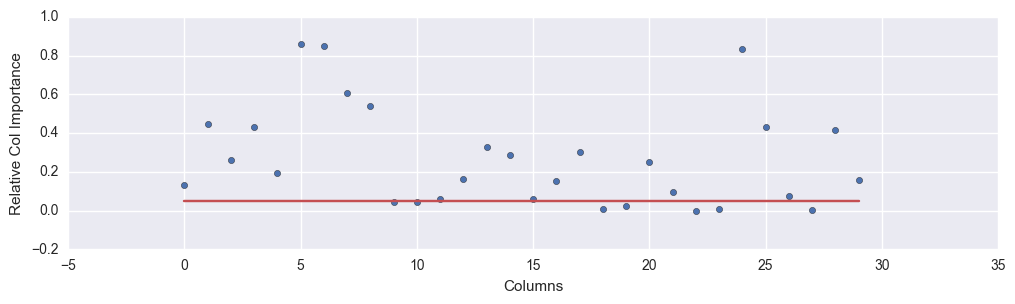

In [55]:
plt.figure(figsize=(12, 3))

# making importance relative
a, b = min(clf.feature_importances_), max(clf.feature_importances_)
cols_imp = (clf.feature_importances_ - a) /b
_ = plt.scatter(range(30), cols_imp)
_ = plt.plot((0, 29), (0.05,0.05), '-r')
_ = plt.xlabel('Columns')
_ = plt.ylabel('Relative Col Importance')

## Scoring

### Random Forest Score

In [ ]:
from sklearn import metrics

In [59]:
print map(lambda x: len(x), [X_test, y_test])

clf.score(X_test, y_test) # 0.79303132333435367 # 0.80252525252525253 # 0.80303030303030298 # 0.80345117845117842

[11880, 11880]


0.80025252525252522

In [60]:
print .79303132333435367 - 0.80345117845117842

print .8285 - 0.80345117845117842, .8285 - .79303132333435367

-0.0104198551168
0.0250488215488 0.0354686766656


### XGBOOST

## Submission

In [88]:

test_ids = RAW_TEST_X.index

predictions = clf.predict(TEST_X)
print (predictions.shape)
predictions_labels = le.inverse_transform(predictions)
# sub = pd.DataFrame(predictions, columns=list(le.classes_))
sub = pd.DataFrame(predictions_labels, columns=['status_group'])
sub.head()


sub.insert(0, 'id', test_ids)
sub.reset_index()
sub.to_csv('submit.csv', index = False)
sub.head()

(14850,)


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [89]:
X.shape

(59400, 30)